In [1]:
import sys
sys.path.append('..')
import interpolator as interp
import numpy as np
import pandas as pd
import tqdm
import pyphot

import corv
from astroquery.sdss import SDSS
import matplotlib.pyplot as plt

lib = pyphot.get_library()
import corv

Could not import Koester models. Contact arseneau@bu.edu if these are needed.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
corv_interp = corv.models.WarwickDAModel('1d_da_nlte').interpolator

In [3]:
#interp.interpolator.purge_cachetables()

In [4]:
filters = lib.content

name_old = '3d_da_lte_h2'
interpolator_old = interp.interpolator.WarwickSpectrum(model = name_old, units = 'flam', wavl_range=(2000, 12000))
photometry_old = interp.interpolator.WarwickPhotometry(model = name_old, bands = filters)

name = '1d_da_nlte'
interpolator = interp.interpolator.WarwickSpectrum(model = name, units = 'flam', wavl_range=(2000, 12000))
photometry = interp.interpolator.WarwickPhotometry(model = name, bands = filters)

Cachetable not found! Building...


100%|██████████| 5/5 [02:53<00:00, 34.79s/it]


In [5]:
plate = 4239
mjd = 55458
fiberid = 274

spec = SDSS.get_spectra_async(plate=plate, fiberID=fiberid, mjd=mjd)[0].get_fits()
wl = 10**spec[1].data['loglam']
fl = spec[1].data['flux']* 1e-17
ivar = spec[1].data['ivar']

(6464.0, 6664.0)

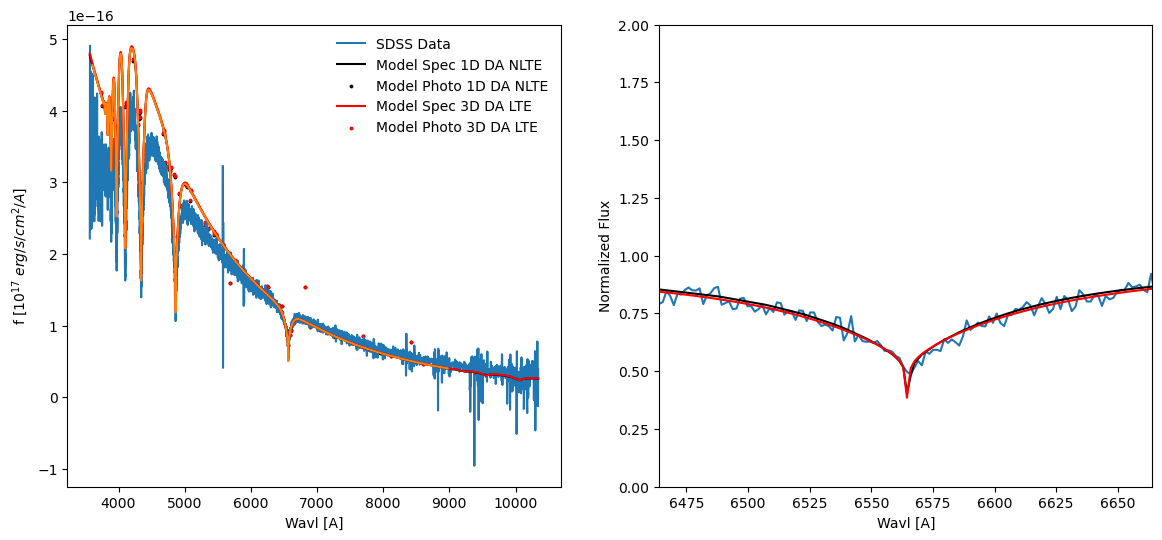

In [8]:
teff, logg, radius, distance = 15862, 8.18, 0.0124, 226

pc_to_m, radius_sun = 3.086775e16, 6.957e8

# 3d_da_lte
fl_model =4*np.pi*interpolator_old(teff, logg) * ((radius*radius_sun) / (distance*pc_to_m))**2
wl_model = interpolator_old.wavl
fl_mod_old = np.interp(wl, wl_model, fl_model)
photo_wavls = np.array([lib[band].lpivot.to('AA').value for band in filters])
mask = (3600 < photo_wavls) * (photo_wavls < 9000)
photo_fl_old = 4*np.pi*photometry_old(teff, logg)[mask] * ((radius*radius_sun) / (distance*pc_to_m))**2 
# 1d_da_nlte
fl_model =4*np.pi*interpolator(teff, logg) * ((radius*radius_sun) / (distance*pc_to_m))**2
wl_model = interpolator.wavl
fl_mod = np.interp(wl, wl_model, fl_model)

photo_wavls = np.array([lib[band].lpivot.to('AA').value for band in filters])
mask = (3600 < photo_wavls) * (photo_wavls < 9000)
photo_fl = 4*np.pi*photometry(teff, logg)[mask] * ((radius*radius_sun) / (distance*pc_to_m))**2 

obsfit = np.polyfit(wl, fl, deg=3)
modfit = np.polyfit(wl, fl_mod, deg=3)
modfit_old = np.polyfit(wl, fl_mod_old, deg=3)


fig, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].plot(wl, fl, label = 'SDSS Data')
ax[0].plot(wl, fl_mod, c='k', label = 'Model Spec 1D DA NLTE')
ax[0].scatter(photo_wavls[mask], photo_fl, c='k', s=3, label = 'Model Photo 1D DA NLTE')
ax[0].plot(corv_interp.wavl, 4*np.pi*corv_interp.model_spec((teff, logg)) * ((radius*radius_sun) / (distance*pc_to_m))**2, zorder=100)
ax[0].plot(wl, fl_mod_old, c='red', label = 'Model Spec 3D DA LTE')
ax[0].scatter(photo_wavls[mask], photo_fl_old, c='red', s=3, label = 'Model Photo 3D DA LTE')
ax[0].set_xlabel('Wavl [A]')
ax[0].set_ylabel(r'f [$10^{17}\text{ }erg/s/cm^2/A$]')
ax[0].legend(framealpha=0)

ax[1].plot(wl, fl/np.poly1d(obsfit)(wl), zorder=0)
ax[1].plot(wl, fl_mod/np.poly1d(modfit)(wl), c='k')
#ax[1].scatter(photo_wavls[mask], photo_fl/np.poly1d(modfit)(photo_wavls[mask]), c='k', s=3)
ax[1].plot(wl, fl_mod_old/np.poly1d(modfit_old)(wl), c='red')
#ax[1].scatter(photo_wavls[mask], photo_fl_old/np.poly1d(modfit_old)(photo_wavls[mask]), c='red', s=3)
ax[1].set_ylim(0, 2)
ax[1].set_xlabel('Wavl [A]')
ax[1].set_ylabel('Normalized Flux')
ax[1].set_xlim(6564-100, 6564+100)

In [7]:
wl**-2

array([7.8632098e-08, 7.8595924e-08, 7.8559687e-08, ..., 9.3583647e-09,
       9.3540500e-09, 9.3497583e-09], shape=(4625,), dtype=float32)